# Notebook 1: Exploring the Raw Traffic Dataset

In this notebook, I conduct an exploratory data analysis of the raw traffic dataset. The aim is to understand:
- The distribution of traffic severity levels
- Temporal patterns (hour, weekday)
- Road-level traffic volumes
- Initial signs of imbalance or skew

This will inform feature engineering and modeling decisions in future notebooks.

A reminder that the dataset was compiled by collecting live data from 10 March 2025 to 20 May 2025 using CRON, from TfL using the corresponding API: https://api-portal.tfl.gov.uk/apis. The script that was used can be found in Scripts/.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the CSV
df = pd.read_csv("../data/tfl_road_status.csv")

#df.head()
df

,road,status,description,timestamp
0,A1,Good,No Exceptional Delays,2025-03-10T00:08:00
1,Western Cross Route,Good,No Exceptional Delays,2025-03-10T00:08:00
2,Southern River Route,Good,No Exceptional Delays,2025-03-10T00:08:00
3,Inner Ring,Good,No Exceptional Delays,2025-03-10T00:08:00
4,Farringdon Cross Route,Good,No Exceptional Delays,2025-03-10T00:08:00
...,...,...,...,...
79483,A2,Good,No Exceptional Delays,2025-05-20T23:34:00
79484,A1,Good,No Exceptional Delays,2025-05-20T23:34:00
79485,Southern River Route,Good,No Exceptional Delays,2025-05-20T23:34:00
79486,A24,Minor,Minor Delays,2025-05-20T23:34:00


In [2]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79488 entries, 0 to 79487
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   road         79488 non-null  object        
 1   status       79488 non-null  object        
 2   description  79488 non-null  object        
 3   timestamp    79488 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 2.4+ MB


## Severity Level Distribution

I first check the frequency of each severity level. This helps to understand class imbalance, which is crucial for choosing evaluation metrics later.


In [3]:
df['status'].value_counts()


status
Good       63108
Minor      11823
Serious     4557
Name: count, dtype: int64

In [4]:
df['description'].value_counts()


description
No Exceptional Delays    63108
Minor Delays             11823
Serious Delays            4557
Name: count, dtype: int64

#### Observation
From the distribution, I observe that severity level 0 dominates the dataset. This class imbalance will need to be handled during model training, e.g. via sampling, weighting, or evaluation metrics like macro F1.


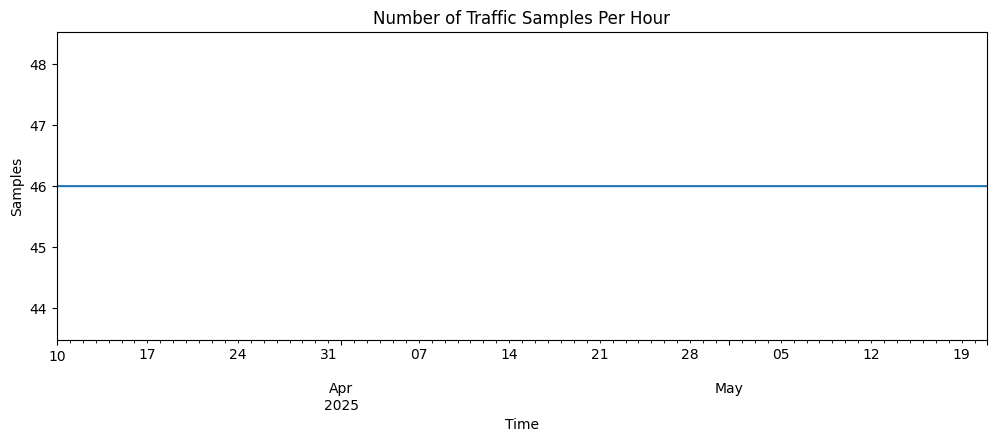

In [5]:
import matplotlib.pyplot as plt

# Number of rows collected over time
df.set_index('timestamp').resample('h').size().plot(figsize=(12, 4), title="Number of Traffic Samples Per Hour")
plt.xlabel("Time")
plt.ylabel("Samples")
plt.show()


#### Observation
 As expected, the number of samples per hour is consistent. This is because the data collection was performed using a scheduled CRON job that scraped data at regular intervals (every 30 minutes), leading to a uniform distribution of samples over time.

In [6]:
pivot = df.pivot_table(index='timestamp', columns='road', values='status', aggfunc='first')
pivot.head()


road,A1,A10,A12,A13,A2,A20,A21,A23,A24,A3,...,A41,Bishopsgate Cross Route,Blackwall Tunnel,City Route,Farringdon Cross Route,Inner Ring,North Circular (A406),South Circular (A205),Southern River Route,Western Cross Route
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-10 00:08:00,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,...,Good,Good,Good,Good,Good,Good,Minor,Good,Good,Good
2025-03-10 00:38:00,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,...,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good
2025-03-10 01:08:00,Minor,Good,Good,Good,Good,Good,Good,Good,Good,Good,...,Good,Good,Good,Serious,Good,Good,Good,Good,Good,Good
2025-03-10 01:38:00,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,...,Good,Good,Good,Good,Good,Good,Good,Good,Good,Minor
2025-03-10 02:08:00,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,...,Minor,Good,Good,Good,Good,Good,Good,Good,Good,Good


In [7]:
severity_map = {
    'Good': 0,
    'Minor Delays': 1,
    'Serious Delays': 2,
        'Serious': 2, 

    'Severe Delays': 3,
    'No Exceptional Delays': 0
}
df['severity_level'] = df['status'].map(severity_map)

In [8]:
df.to_csv("../data/cleaned_tfl_road_status.csv", index=False)


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79488 entries, 0 to 79487
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   road         79488 non-null  object        
 1   status       79488 non-null  object        
 2   description  79488 non-null  object        
 3   timestamp    79488 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 2.4+ MB

First few rows:
                     road status            description           timestamp
0                      A1   Good  No Exceptional Delays 2025-03-10 00:08:00
1     Western Cross Route   Good  No Exceptional Delays 2025-03-10 00:08:00
2    Southern River Route   Good  No Exceptional Delays 2025-03-10 00:08:00
3              Inner Ring   Good  No Exceptional Delays 2025-03-10 00:08:00
4  Farringdon Cross Route   Good  No Exceptional Delays 2025-03-10 00:08:00

Missing values:
road           0
status         0
desc

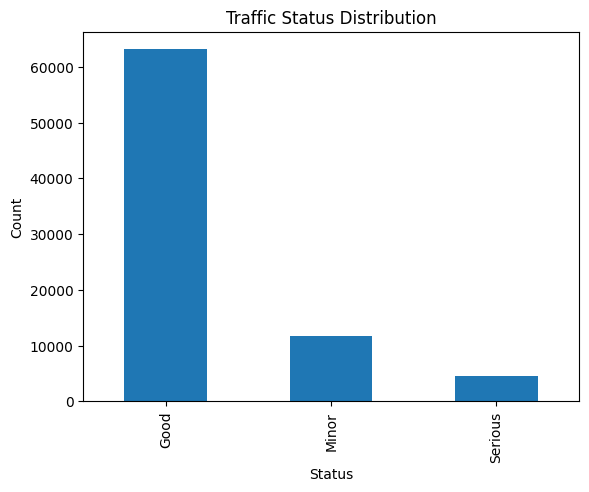

<Figure size 1200x600 with 0 Axes>

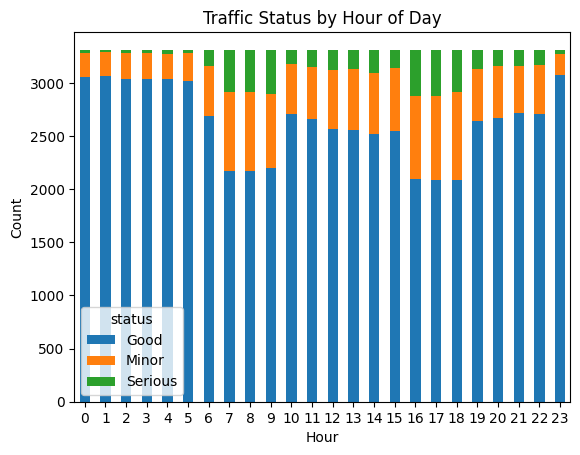

<Figure size 1200x600 with 0 Axes>

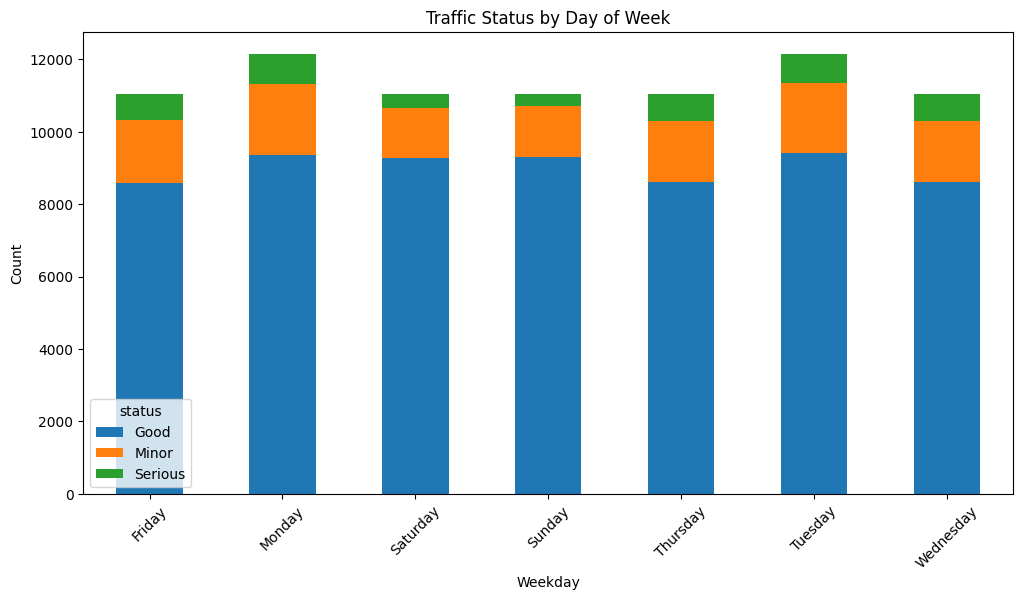

Cleaned data saved


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/tfl_road_status.csv")

# Converting timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Inspecting data
print("Data info:")
df.info()

print("\nFirst few rows:")
print(df.head())

# checking for missing values
print("\nMissing values:")
print(df.isnull().sum())

# checking for duplicates
print("\nDuplicates:")
print(df.duplicated().sum())

# count observations per road
print("\nRoad observation counts:")
print(df['road'].value_counts())

# traffic status distribution
df['status'].value_counts().plot(kind='bar', title="Traffic Status Distribution")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()

# traffic status by hour of day
plt.figure(figsize=(12, 6))
df.groupby('hour')['status'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title("Traffic Status by Hour of Day")
plt.ylabel("Count")
plt.xlabel("Hour")
plt.xticks(rotation=0)
plt.show()

# traffic status by day of week
plt.figure(figsize=(12, 6))
df.groupby('weekday')['status'].value_counts().unstack().plot(
    kind='bar', stacked=True, figsize=(12, 6)
)

plt.title("Traffic Status by Day of Week")
plt.ylabel("Count")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.show()

# Saving cleaned version with new columns
df.to_csv("../data/cleaned_tfl_road_status.csv", index=False)
print("Cleaned data saved")


## Summary

- The dataset is heavily imbalanced, with severity level 0 dominating.
- Traffic volume varies significantly across roads and times of day.
- Rush hours (morning/evening) have elevated activity.
- These patterns motivate including temporal and road-level features during feature engineering.
